In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from scipy.io import loadmat
import math
import os
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from scipy.optimize import minimize
from scipy.optimize import rosen
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 5.0) # Set default figure size

## Load data

In [2]:
%%time
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')


X_train, y_train = train_data['X'], train_data['y']
X_test, y_test = test_data['X'],test_data['y']


print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)


Training (32, 32, 3, 73257) (73257, 1)
Test (32, 32, 3, 26032) (26032, 1)
Wall time: 2.1 s


## Preprocessing

In [3]:
# Transpose the image arrays to image_index,row,column and color channel
X_train = X_train.transpose((3,0,1,2))
X_test = X_test.transpose((3,0,1,2))


print("Training", X_train.shape)
print("Test", X_test.shape)

# total number of images
num_images = X_train.shape[0] + X_test.shape[0]

print("Total Number of Images", num_images)


Training (73257, 32, 32, 3)
Test (26032, 32, 32, 3)
Total Number of Images 99289


In [4]:
# function for plotting images

def plot_images(img, labels, nrows, ncols,labels_pred=None):#,cmap = 'Colormap'):
    """ Plot nrows x ncols images
    """
    plt.rcParams['figure.figsize'] = (20.0, 5.0)
    fig, axes = plt.subplots(nrows, ncols)
    # Randomly select nrows * ncols images
    rs = np.random.choice(img.shape[0], nrows*ncols)
    #for i, ax in enumerate(axes.flat):
    for i, ax in zip(rs,axes.flat):
         # Predictions are not passed
        if labels_pred is None:
            title = "True: {0}".format(labels[i])
        
        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format((labels[i]), labels_pred[i])
            
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0],cmap = 'binary')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)

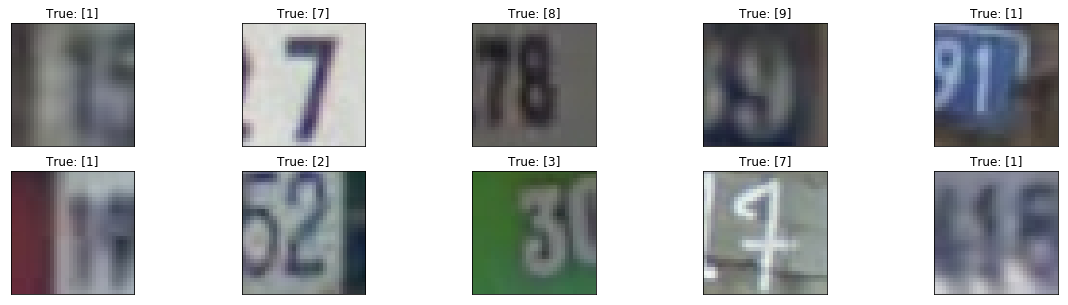

In [5]:
# Plot some training set images
plot_images(X_train, y_train, 2, 5)

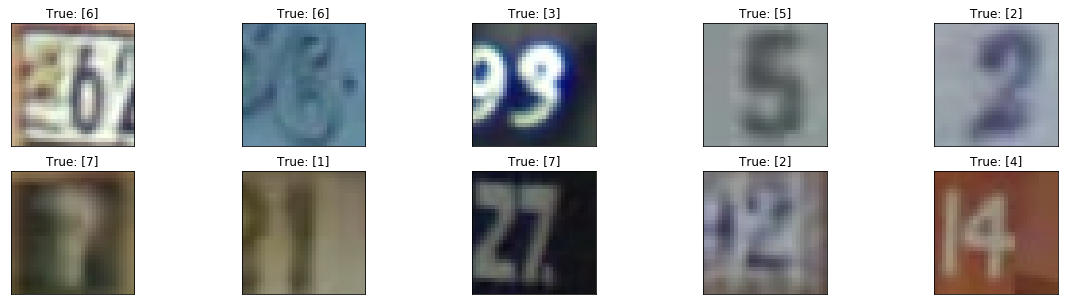

In [6]:
# Plot some test set images
plot_images(X_test, y_test, 2, 5)

In [7]:
# identify unique classes
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


In [8]:
# change label value from 10 to 0
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


In [9]:
print("Training", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Training (73257, 32, 32, 3) (73257, 1)
Test (26032, 32, 32, 3) (26032, 1)


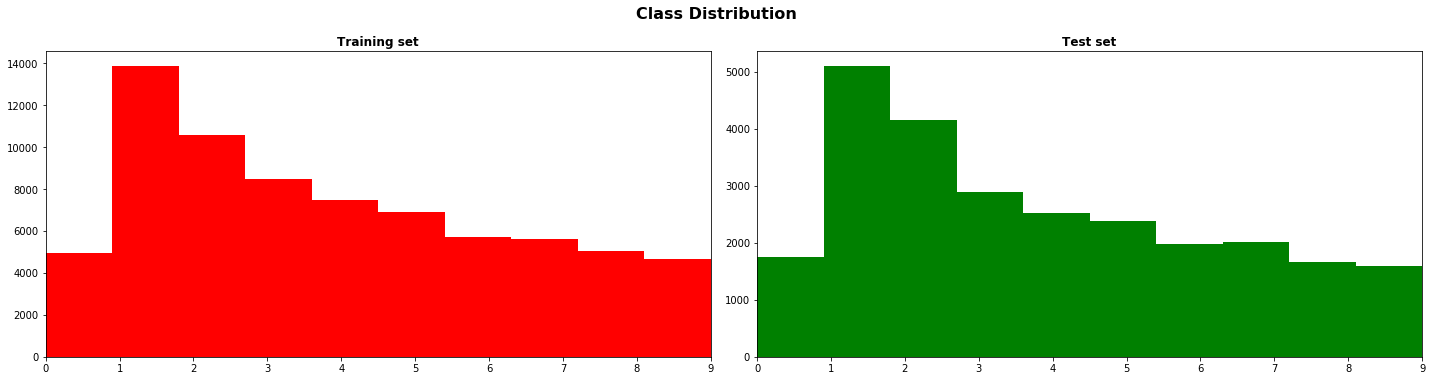

In [10]:
# check class distribution in both sets
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=16, fontweight='bold', y=1.05)

ax1.hist(y_train, color='r' ,bins=10)
ax1.set_title("Training set",fontsize=12,fontweight='bold')
ax1.set_xlim(0, 9)

ax2.hist(y_test, color='g', bins=10)
ax2.set_title("Test set",fontsize=12,fontweight='bold')

fig.tight_layout()

Wall time: 6.84 s


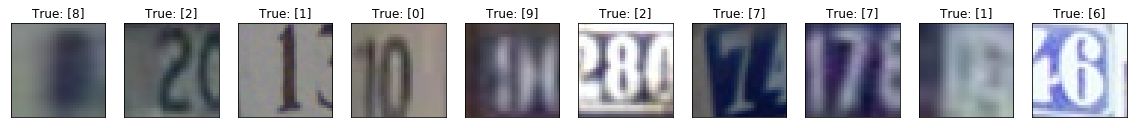

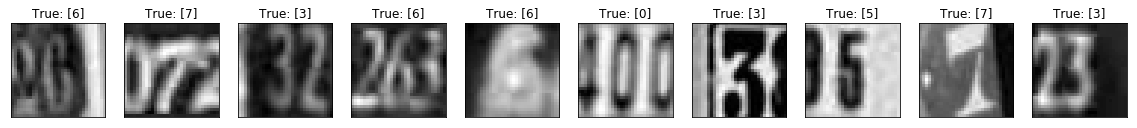

In [11]:
%%time
# convert images form RGB to Grayscale for reducing dimensionality 
def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    return np.expand_dims(np.dot(images, [0.2989, 0.5870, 0.1140]), axis=3)

# Transform the images to greyscale
train_greyscale = rgb2gray(X_train).astype(np.float32)
test_greyscale = rgb2gray(X_test).astype(np.float32)

plot_images(X_train, y_train, 1, 10)
plot_images(train_greyscale, y_train, 1, 10)

In [12]:
X_train = train_greyscale
X_test = test_greyscale

# check shapes of data

print('Training set', X_train.shape, y_train.shape)

print('Test set', X_test.shape, y_test.shape)

Training set (73257, 32, 32, 1) (73257, 1)
Test set (26032, 32, 32, 1) (26032, 1)


In [13]:
# Check image size
img_size = X_train.shape[1]
print('image_size:',img_size)

# Check grayscale image channel size
num_channels = X_train.shape[-1]
print('num_channels:',num_channels)

# Check label
num_classes = y_train.shape[1]
print('num_classes,',num_classes)

image_size: 32
num_channels: 1
num_classes, 1


In [14]:
# apply normalization to images

# mean on the training data
train_mean = np.mean(X_train, axis=0)

# std on the training data
train_std = np.std(X_train, axis=0)

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean)  / train_std

In [15]:
# reshape train and test data to 1D insted of 3D

X_train_re = np.reshape(X_train, (X_train.shape[0], -1))
X_test_re = np.reshape(X_test, (X_test.shape[0], -1))

print(X_train_re.shape)
print(X_test_re.shape)
print('')
print(y_train.shape)

(73257, 1024)
(26032, 1024)

(73257, 1)


In [16]:
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
print(y_train)
print('')
print(y_test)

[1 9 2 ... 1 6 9]

[5 2 1 ... 7 6 7]


### PCA Analysis

pca :  [5.82936048e-01 5.98876811e-02 5.28943289e-02 ... 4.50525973e-08
 4.30547876e-08 4.25626943e-08]
variance :  [0.58293605 0.64282373 0.69571806 ... 0.99999984 0.99999988 0.99999992]


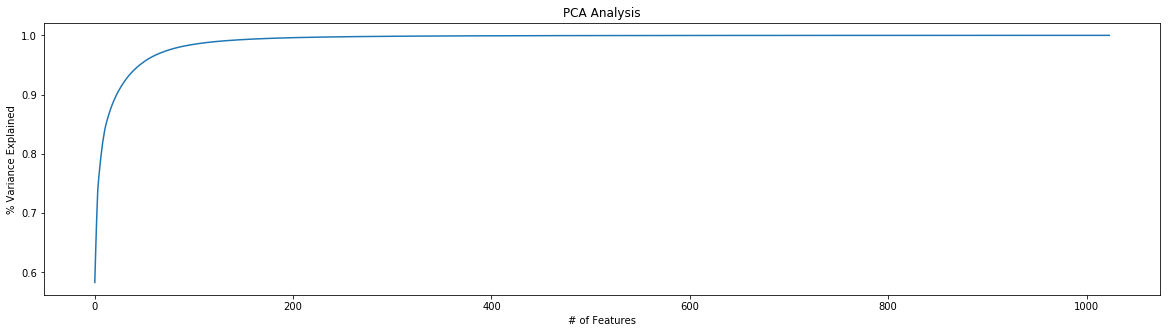

In [17]:
def apply_PCA(data) :
    pca = PCA()
    transform_data = pca.fit_transform(data)
    #Explained variance ratio
    print('pca : ', pca.explained_variance_ratio_)

    var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=8))
    print('variance : ', var)

    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.plot(var)
    plt.show()
    #Cumulative variance
    pca.explained_variance_ratio_.sum()
    return transform_data

ptd = apply_PCA(X_train_re)

In [18]:
# choose minimum number of principal components that 95% of the variance is retained
pca = PCA(.95)
pca.fit(X_train_re)
print(pca.n_components_) # components that explain 95% of data
X_train_re = pca.transform(X_train_re)
X_test_re = pca.transform(X_test_re)

47


## SVM Classification

### Choosing best hyperparameters

In [19]:
%%time
# Set the hyperparameters by cross-validation for SVM algorithms
# choose parameters by experiment
# first best gamma= 0.001 and C=100
# second best gamma= 0.0005, C=100
# third best gamma = 0.00025, C = 112
# it take about 3 minutes
tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-4,5e-4,2.5e-4],'C': [1,5,10,100,112]}
# randomized serach to choose best hyperparameters
clf = RandomizedSearchCV(SVC(),param_distributions=tuned_parameters, n_iter=15)
# train model only on 5000 rows (based on training only on 5000 rowes choose hyper parameters) 
clf.fit(X_train_re[:5000], y_train[:5000]) 

Wall time: 1min 57s


### Model training

In [20]:
%%time 
# train model with best possible hyperparameters on whole dataset
# it takes about 12 minutes
# with probability = true it takes 53 minutes
C = clf.best_params_['C']
gamma = clf.best_params_['gamma']
kernel = clf.best_params_['kernel']
# train whole data with best parameters
clf = SVC(C = C, gamma = gamma,kernel = kernel)
clf.fit(X_train_re, y_train)
y_pred = clf.predict(X_test_re)


Wall time: 12min 39s


### Classification report and Confusion Matrix

In [22]:
# classification report
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.72      0.76      0.74      1744
          1       0.80      0.89      0.84      5099
          2       0.84      0.83      0.84      4149
          3       0.74      0.66      0.70      2882
          4       0.82      0.83      0.82      2523
          5       0.81      0.71      0.75      2384
          6       0.72      0.74      0.73      1977
          7       0.81      0.79      0.80      2019
          8       0.73      0.63      0.68      1660
          9       0.65      0.73      0.68      1595

avg / total       0.78      0.78      0.78     26032



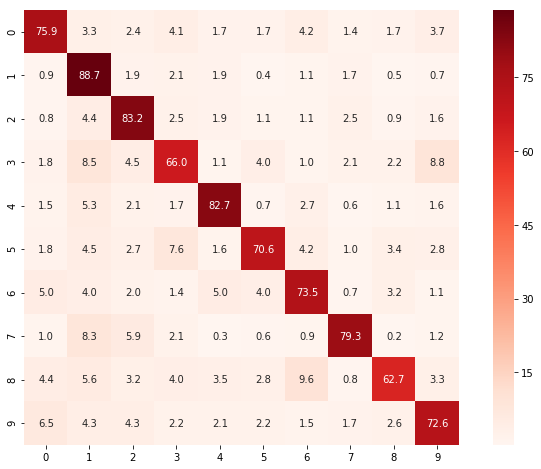

In [23]:
# confusion matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(np.ravel(y_test), y_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True)

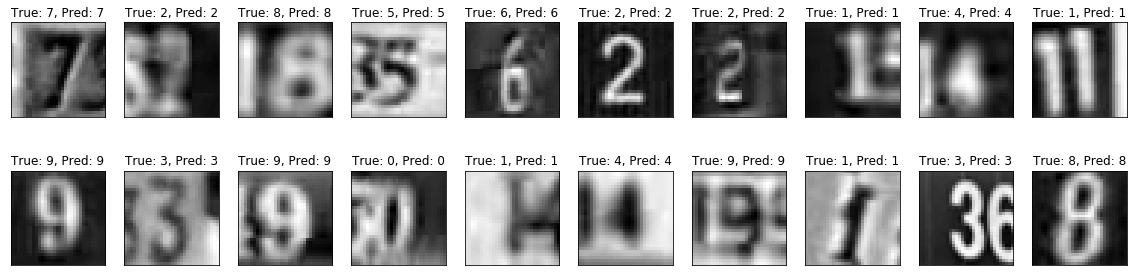

In [24]:
# print correct predicted images
correct_pre =  y_pred == y_test
plot_images(X_test[correct_pre], y_test[correct_pre], 2, 10,labels_pred=y_pred[correct_pre])

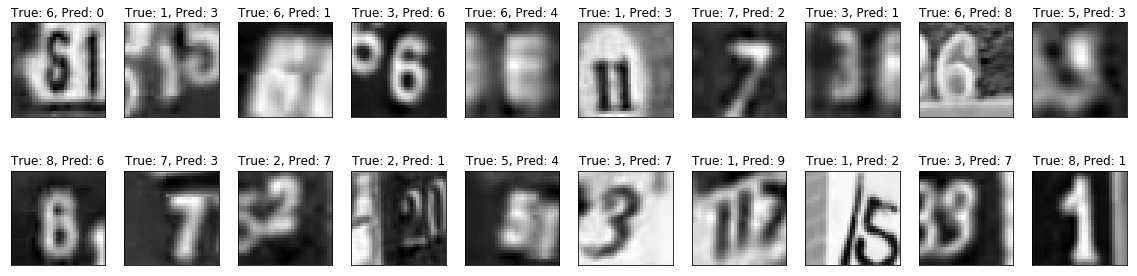

In [25]:
# print incorrect predicted images
incorrect_pre = y_pred != y_test
plot_images(X_test[incorrect_pre], y_test[incorrect_pre], 2, 10,labels_pred=y_pred[incorrect_pre])

## Random Forest

### Choosing hyperparameters

In [32]:
%%time
# hyperparameters tunning (depth of forest and number of trees) for Random Forest classifier on 2000 rows
# it takes 33minutes

avg_score_matrix = []
for i in range(1,30): # depth of randome forest
    temp_score = []
    for j in range(1,20): # number of (trees /10)
        mod = RandomForestClassifier(n_estimators=j*10,max_depth = i)
        scores = cross_val_score(mod, X_train_re[:2000], y_train[:2000], cv=5)
        temp_score.append(np.mean(scores))
    avg_score_matrix.append(temp_score)

Wall time: 31min 21s


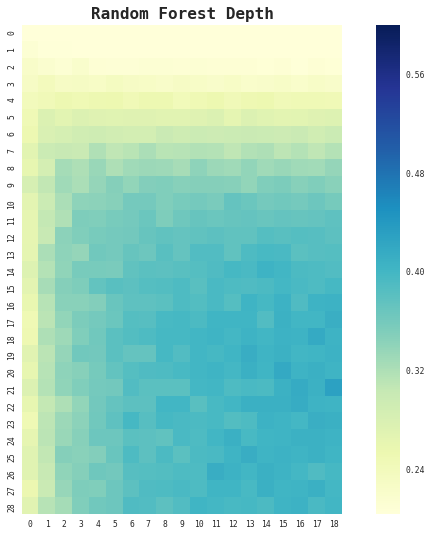

In [26]:
# plotting based on average score matrix, higher is darker
sns.set(context="paper", font="monospace")
f, ax = plt.subplots(figsize=(12, 9))
plt.title("Random Forest Depth", { 'weight' : 'bold','size':'16'})
plt.ylabel("depth")
plt.xlabel("tree number")
sns.heatmap(avg_score_matrix, vmax=.6, square=True,cmap = 'YlGnBu')
plt.show()

In [27]:
# best hyperparameters
score_matrix = np.matrix(avg_score_matrix)
# best hyperparameters
i,j = np.unravel_index(score_matrix.argmax(), score_matrix.shape)
print('max depth:',i)
print('number of trees:',j*10)


max depth: 21
number of trees: 180


### Model training

In [33]:
%%time
# train whole data based on best hyperparameters
mod = RandomForestClassifier(n_estimators=j*10,max_depth = i)
clf = mod.fit(X_train_re,y_train)
y_pred = mod.predict(X_test_re)

Wall time: 1min 55s


### Classification Report and Confusion Matrix

In [34]:
# classification report
print(classification_report(np.ravel(y_test),y_pred))

             precision    recall  f1-score   support

          0       0.76      0.55      0.64      1744
          1       0.56      0.92      0.70      5099
          2       0.64      0.80      0.71      4149
          3       0.60      0.50      0.54      2882
          4       0.70      0.74      0.72      2523
          5       0.73      0.55      0.63      2384
          6       0.76      0.42      0.54      1977
          7       0.81      0.60      0.69      2019
          8       0.87      0.32      0.47      1660
          9       0.76      0.53      0.62      1595

avg / total       0.69      0.65      0.64     26032



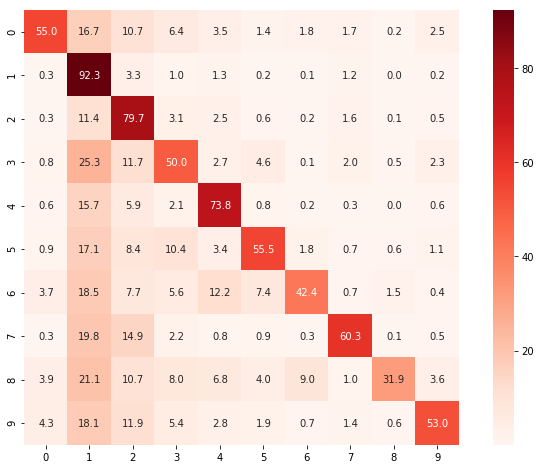

In [35]:
# confusion matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
ax = sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True)
